<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment2/workbook-A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
# Install PyTorch Geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.5MB 7.4MB/s 
     |████████████████████████████████| 1.5MB 7.6MB/s 
     |████████████████████████████████| 215kB 9.2MB/s 
     |████████████████████████████████| 235kB 14.6MB/s 
     |████████████████████████████████| 2.2MB 15.3MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 


In [2]:
import torch
import requests
import io
import pickle
import json

def download(url, filetype='tensor'):
    if filetype not in ['tensor', 'pickle', 'json']:
        raise ValueError('Incorrect filetype')
    response = requests.get(url)
    response.raise_for_status()
    if filetype == 'tensor':
        return torch.load(io.BytesIO(response.content))
    elif filetype == 'pickle':
        return pickle.load(io.BytesIO(response.content))
    elif filetype == 'json':
        return json.load(io.BytesIO(response.content))

# Task 1

In [3]:
## Download the dataset for image retrieval ##
data_1 = download('https://surfdrive.surf.nl/files/index.php/s/EH2tN7JiZnwdIXg/download', filetype='tensor')
data_metadata = download('https://github.com/pmernyei/wiki-cs-dataset/raw/master/dataset/metadata.json', filetype='json')

In [4]:
count=0
print(data_1.train_mask.shape)
for i in data_1.train_mask:
  if i==True:
    count=count+1
print(count)
print(data_1.test_mask)

torch.Size([10701])
522
tensor([False, False,  True,  ...,  True,  True, False])


In [5]:
print(data_1.x.shape)
print(data_1.train_mask.shape)
print(sum(data_1.train_mask))
print(sum(data_1.test_mask))
print(data_1.y.shape)

torch.Size([10701, 300])
torch.Size([10701])
tensor(522)
tensor(5348)
torch.Size([10701])


In [6]:
num_node = data_1.x.shape[0]
num_edge = data_1.edge_index.shape[1]
num_node_feature = data_1.x.shape[1]
num_class = int(max(data_1.y)+1)
num_label = sum(data_1.train_mask)

print(f'Num nodes: {num_node}')
print(f'Num edges: {num_edge}')
print()
print(f'Num node features: {num_node_feature}')
print(f'Num classes: {num_class}')
print()
print(f'Num training labels: {num_label}')

Num nodes: 10701
Num edges: 251927

Num node features: 300
Num classes: 10

Num training labels: 522


In [7]:
num_features=num_node_feature
num_classes=num_class

In [8]:
for i in range(num_class):
    print('{}: {}'.format(i, data_metadata['labels'][str(i)]))

0: Computational linguistics
1: Databases
2: Operating systems
3: Computer architecture
4: Computer security
5: Internet protocols
6: Computer file systems
7: Distributed computing architecture
8: Web technology
9: Programming language topics


In [9]:
def print_node(idx, url=True, label=True):
    node_info = data_metadata['nodes'][idx]
    print(f'--Node {idx}--')
    if url:
        title = node_info['title']
        wiki_url = 'https://en.wikipedia.org/wiki/' + title
        print(wiki_url)
    if label:
        print('Label:', node_info['label'])
    print()

In [10]:
for i in range(10):
    print_node(i)

--Node 0--
https://en.wikipedia.org/wiki/Twilio
Label: Distributed computing architecture

--Node 1--
https://en.wikipedia.org/wiki/Program_compatibility_date_range
Label: Operating systems

--Node 2--
https://en.wikipedia.org/wiki/SYSTAT_(DEC)
Label: Operating systems

--Node 3--
https://en.wikipedia.org/wiki/List_of_column-oriented_DBMSes
Label: Databases

--Node 4--
https://en.wikipedia.org/wiki/Stealth_wallpaper
Label: Computer security

--Node 5--
https://en.wikipedia.org/wiki/Scalable_TCP
Label: Internet protocols

--Node 6--
https://en.wikipedia.org/wiki/Carrier_IQ
Label: Computer security

--Node 7--
https://en.wikipedia.org/wiki/ACF2
Label: Operating systems

--Node 8--
https://en.wikipedia.org/wiki/Dorkbot_(malware)
Label: Computer security

--Node 9--
https://en.wikipedia.org/wiki/Lout_(software)
Label: Programming language topics



## Build and Train Model

In [11]:
## Build the article retrieval system ##
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels1):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, 256)  # the node's word vector (with size num_features) is  
                                                              # transformed to a vector of size hidden_channels
        self.conv11 = SAGEConv(256, 128)
        self.conv12 = SAGEConv(128, 32)
        self.conv2 = SAGEConv(32, num_classes)  # we convert our nodes from hidden_channels to num_classes, the
                                                             # last update step turns a node's state into a node-class prediction

    def forward(self, x, edge_index):
        # x = (1), all nodes contain information about itself (x_size, num_features)
        x = self.conv1(x, edge_index) # x = (2), update all nodes for the first time, returning (x_size, hidden_channels)
        x = x.relu()  # activation function
        x = F.dropout(x, p=0.8, training=self.training)  # attempt to combat overfitting, as we only have few labels
        self.x1 = self.conv11(x, edge_index)
        x = self.conv11(x, edge_index)
        x = x.relu()
        x = self.conv12(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)  # x = (3), update all nodes again, returning (x_size, num_classes)
                                       # this final update transforms each node embedding to a class prediction
                                       # we do not apply an activation, as the PyTorch CCE calculation
                                       # takes care of treating this output as 'softmax'.
        return x

    def get_firstlayer(self, x, edge_index):
        return self.x1

In [12]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
data_1.to(DEVICE)
model_gnn = GraphSAGE(hidden_channels1=16).to(DEVICE) # initialize our GNN with a hidden size of 16
print(model_gnn)

# same loss and optimizer as before
loss_func = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=0.01, weight_decay=5e-4)

def train_gnn():
    model_gnn.train()  # set the model to training 'mode' (i.e., apply dropout)
    optimizer.zero_grad()  # set gradients to 0
    out = model_gnn(data_1.x, data_1.edge_index)  # propagate the data through the model
    loss = loss_func(out[data_1.train_mask], data_1.y[data_1.train_mask])  # compute the loss based on our training mask
    loss.backward()  # derive gradients
    optimizer.step()  # update all parameters based on the gradients
    return loss

def test_gnn(mask):
    model_gnn.eval()  # set the model to evaluation 'mode' (don't use dropout)
    out = model_gnn(data_1.x, data_1.edge_index)  # propagate the data through the model
    pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
    test_correct = pred[mask] == data_1.y[mask]  # create a tensor that evaluates whether predictions were correct
    test_acc = int(test_correct.sum()) / int(mask.sum())  # get the accuracy
    return test_acc



train_accs = []
test_accs = []
epochs = 80
for epoch in range(1, epochs+1): 
    loss = train_gnn()  # do one training step over the entire dataset
    train_acc = test_gnn(data_1.train_mask)  # compute the training accuracy
    test_acc = test_gnn(data_1.test_mask)  # compute the test accuracy
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)  # save accuracies so we can plot them
    test_accs.append(test_acc)

GraphSAGE(
  (conv1): SAGEConv(300, 256)
  (conv11): SAGEConv(256, 128)
  (conv12): SAGEConv(128, 32)
  (conv2): SAGEConv(32, 10)
)
Epoch: 001, Loss: 2.2796, Train Acc: 0.1762, Test Acc: 0.1703
Epoch: 002, Loss: 2.1162, Train Acc: 0.2203, Test Acc: 0.2285
Epoch: 003, Loss: 2.3576, Train Acc: 0.3238, Test Acc: 0.3123
Epoch: 004, Loss: 2.0673, Train Acc: 0.2165, Test Acc: 0.1960
Epoch: 005, Loss: 2.0584, Train Acc: 0.1743, Test Acc: 0.1679
Epoch: 006, Loss: 1.9809, Train Acc: 0.1839, Test Acc: 0.1776
Epoch: 007, Loss: 1.9581, Train Acc: 0.4272, Test Acc: 0.4172
Epoch: 008, Loss: 1.7998, Train Acc: 0.4751, Test Acc: 0.4665
Epoch: 009, Loss: 1.7557, Train Acc: 0.4904, Test Acc: 0.4867
Epoch: 010, Loss: 1.6268, Train Acc: 0.4943, Test Acc: 0.5067
Epoch: 011, Loss: 1.5789, Train Acc: 0.5517, Test Acc: 0.5279
Epoch: 012, Loss: 1.4549, Train Acc: 0.5939, Test Acc: 0.5707
Epoch: 013, Loss: 1.3821, Train Acc: 0.5939, Test Acc: 0.5785
Epoch: 014, Loss: 1.3017, Train Acc: 0.5920, Test Acc: 0.5754


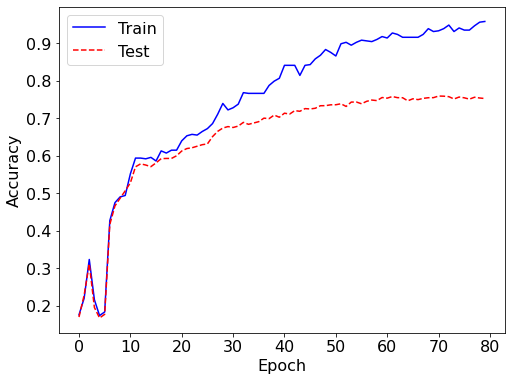

In [13]:
from numpy import mean
import heapq
import matplotlib.pyplot as plt
def plot_train(train_accs, test_accs):
    fig, ax = plt.subplots(figsize=(8,6))
    fnt=16
    ax.plot(train_accs, color='blue', label='Train')
    ax.plot(test_accs, color='red', linestyle='--', label='Test')
    ax.legend(fontsize=fnt)
    ax.tick_params(axis='both', labelsize=fnt)
    ax.set_xlabel('Epoch', fontsize=fnt)
    ax.set_ylabel('Accuracy', fontsize=fnt)
plot_train(train_accs,test_accs)

In [14]:
# print(model_gnn(data_1.x, data_1.edge_index).shape)
# print(model_gnn(data_1.x, data_1.edge_index)[0])
# print(model_gnn.get_firstlayer(data_1.x,data_1.edge_index).shape)
# print(model_gnn.get_firstlayer(data_1.x,data_1.edge_index)[0])
#extract the feature from GNN layer
layers=model_gnn.get_firstlayer(data_1.x,data_1.edge_index)
print(len(data_1.x))
count1=0
count2=0
for i in range(len(data_1.x)):
  if data_1.train_mask[i] or data_1.test_mask[i]:
    count1=count1+1
  if (not data_1.train_mask[i]) and (not data_1.test_mask[i]):
    count2=count2+1
print(count1)
print(count2)


10701
5870
4831


## Test Similarity

In [15]:
#we use the first 3000 data to test the similarity

num=1000
edge3000=[]
for i,j in data_1.edge_index.t():
  edge=[]
  if i.item()<num and j.item()<num:
    edge.append(i.item())
    edge.append(j.item())
    edge3000.append(edge)
print(len(edge3000))

#calculate the similarity in the first 3000 images
total_similar=[]
word_similar=[]

for i in range(num):
  
  similar=[]
  similar1=[]
  for j in range(num):
    similar.append(round(torch.sum((layers[j]-layers[i])**2).item(),3))
    similar1.append(round(torch.sum((data_1.x[j]-data_1.x[i])**2).item(),3))
    #print(i,j)
  #print(i)
  total_similar.append(similar)
  word_similar.append(similar1)
print(total_similar)
print(word_similar)


# print(heapq.nsmallest(6, total_similar[0])) # Prints [-4, 1, 2]
# max_index = map(total_similar[0].index, heapq.nsmallest(6, total_similar[0])) 
# max_index = list(max_index)
# print(max_index)
# print(data_1.y[max_index])
# for i in range(6):
#   print_node(max_index[i])

2475


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
#find out all the neighbor
all_neighbor=[]
for i in range(num):
  edge=[]
  for j,k in edge3000:
    if j==i:
      edge.append(k)
    if k==i:
      edge.append(j) 
  all_neighbor.append(edge)


In [17]:
ave_dis=[]
word_ave_dis=[]
for i in range(num):   
  dis=[]
  dis1=[]
  sort_similar=sorted(total_similar[i]) 
  sort_similar1=sorted(word_similar[i])
  for j in all_neighbor[i]: 
    value=total_similar[i][j] 
    ind=sort_similar.index(value)  #find the rank of its neighbor
    value1=word_similar[i][j]
    word_ind=sort_similar1.index(value1)
    dis.append(ind) 
    dis1.append(word_ind)
  if len(dis)!=0: 
    ave_dis.append(round(mean(dis),3)) #calculate the average rank
    word_ave_dis.append(round(mean(dis1),3))



## Compare Similarity between GNN and Doc_embedding

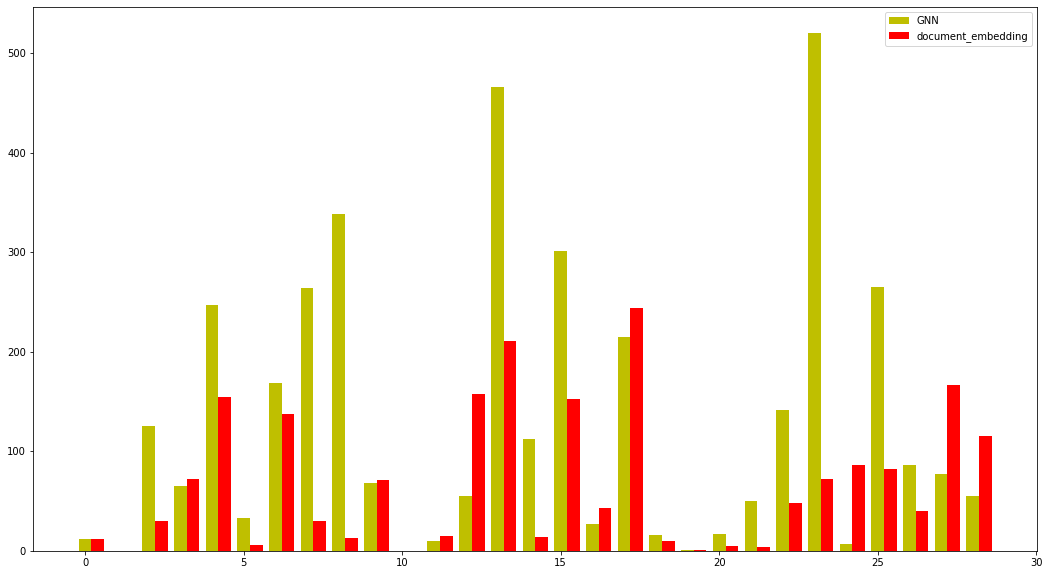

In [18]:
top=30

x =list(range(len(ave_dis[1:top])))
total_width, n = 0.8, 2
width = total_width / n
plt.figure(figsize=(18,10))
plt.bar(x, ave_dis[1:top], width=width, label='GNN',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, word_ave_dis[1:top], width=width, label='document_embedding',fc = 'r')
plt.legend()
plt.show()


## Tsne

In [19]:
%matplotlib inline
from sklearn.manifold import TSNE
from matplotlib import cm
from matplotlib.patches import Patch
from IPython.display import HTML, display, Javascript
import matplotlib.pyplot as plt

'''
A function that plots a models embeddings, and colors them either according to 
the original labels or the predicted labels. Additionally, we can highlight 
individual datapoints in this embedding.
'''
idx_to_label = {i: data_metadata['labels'][str(data_1.y[i].item())] for i in range(3000)}
def visualize(y=None, out=None, z=None, hl=None, text_type='idx', return_z=False, color_pred=False):
    if out is None and z is None:
        print('Must supply either model or TSNE output!')
        return
    if (y is None and out is None) or (y is None and color_pred is False):
        print('Must supply either y or calculate y from out!')
        return

    if z is None: # create our embedding if it was not provided
        z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    
    if y is None and color_pred is True:
        y = out.argmax(dim=1) # if no labels are provided, take the model's output
    
    # initialize our figure / plotting related settings
    fig, ax = plt.subplots()
    fig.set_size_inches((10, 10))
    
    ax.set_xticks([])
    ax.set_yticks([])

    colors = list(plt.cm.Paired.colors)[0:num_classes]
    #labels = [idx_to_label[i] for i in range(num_classes)]
    labels=[data_metadata['labels'][str(i)] for i in range(num_classes)]
    
    c = [colors[i] for i in y]
    
    s=50
    scatter = ax.scatter(z[:, 0], z[:, 1], s=s, c=c)

    # if we provide node indices to highlight, do so
    if hl is not None:
        hl_z = z[hl]
        hl_y = y[hl]
        c = [colors[i] for i in hl_y]
        scatter_hl = ax.scatter(hl_z[:, 0], hl_z[:, 1], s=s, c=c, edgecolor='black')
        for i, h_i in enumerate(hl):  # and mark them, so we can find our nodes
            plt.arrow(hl_z[i, 0], hl_z[i, 1]-10, 0, 9, length_includes_head=True, alpha=1, head_width=2, color='black')
            if text_type == 'idx':  # either display the node's idx
                text = str(h_i)
            elif text_type == 'title':  # or the paper's title
                limit = 80
                text = "null"
                if len(text) > limit:
                    text = text[:limit-3] + '...'
            #plt.text(hl_z[i, 0]-.1, hl_z[i, 1]-10.5, text, horizontalalignment='center', verticalalignment='top', fontsize=10,
                    #bbox=dict(facecolor='gray', alpha=0.3, edgecolor='black', pad=1.0))
            
    # create our legend
    handles = [Patch(color=c, label=l) for c, l in zip(colors, labels)]
    ax.legend(handles=handles)
    plt.show()

    # rescale the cell this is ran on, and center-align the output
    display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 750})'))
    display(HTML("""<style>#output-body {display: flex;align-items: center;justify-content: center;}</style>"""))

    if return_z:
        return z

In [20]:
print([idx_to_label[i] for i in range(num_classes)])

['Distributed computing architecture', 'Operating systems', 'Operating systems', 'Databases', 'Computer security', 'Internet protocols', 'Computer security', 'Operating systems', 'Computer security', 'Programming language topics']


In [21]:
out = model_gnn(data_1.x, data_1.edge_index)  # get node embeddings from the GNN
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())  # and create a TSNE visualization


In [22]:
z1 = TSNE(n_components=2).fit_transform(data_1.x.detach().cpu().numpy())

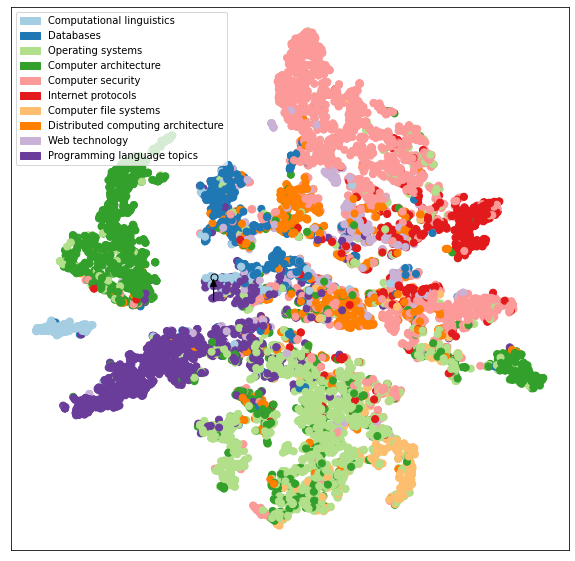

<IPython.core.display.Javascript object>

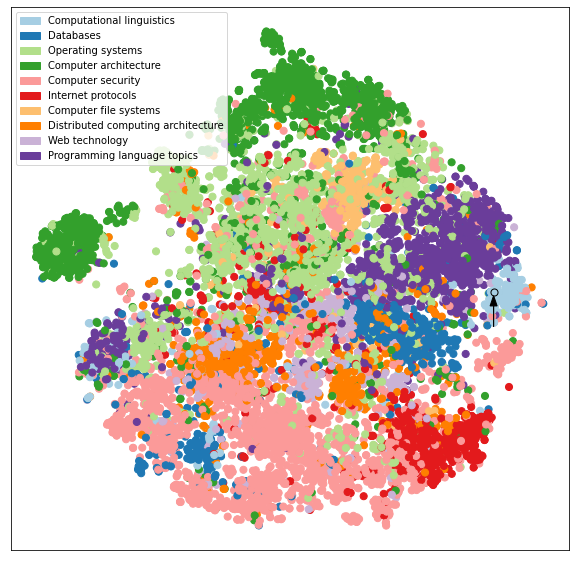

<IPython.core.display.Javascript object>

In [23]:
visualize(z=z, y=data_1.y, hl=[10], text_type='title')
visualize(z=z1, y=data_1.y, hl=[10], text_type='title')

# Task 2

In [24]:
import torch
import random
import numpy as np
import seaborn as sns

from tqdm import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt
from torch_geometric.nn import SAGEConv
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [25]:
## Download the anomaly evaluation data ##
data_2 = download('https://surfdrive.surf.nl/files/index.php/s/EzMkh3SZbsbJb2i/download', filetype='tensor')
is_anomaly = download('https://surfdrive.surf.nl/files/index.php/s/wrK5xipcIC9DHhu/download', filetype='pickle')

In [26]:
total_node = data_2.x.shape[0]
total_edge = data_2.edge_index.shape[1]
new_node = total_node - num_node
new_edge = total_edge - num_edge
print(f'Num new nodes: {new_node}')
print(f'Num new edges: {new_edge}')

Num new nodes: 2000
Num new edges: 50176


In [27]:
print(f'Indices of new nodes are {num_node}...{total_node-1}')
print('The first 1000 are real articles, the last 1000 are anomaly articles')
print('You can use the map "is_anomaly" to identify whether a node is an anomaly or not')
e_real = num_node+500
e_anomaly = num_node+1500
print(f'E.g., is_anomaly[{e_real}] = {is_anomaly[e_real]} and is_anomaly[{e_anomaly}] = {is_anomaly[e_anomaly]}')

Indices of new nodes are 10701...12700
The first 1000 are real articles, the last 1000 are anomaly articles
You can use the map "is_anomaly" to identify whether a node is an anomaly or not
E.g., is_anomaly[11201] = 0 and is_anomaly[12201] = 1


### Define VAE model

This class includes both the encoder and the decoder of VAE.

In [28]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.gcnconv1 = SAGEConv(input_dim, 256)
        self.gcnconv2 = SAGEConv(256, 128)
        self.gcnconv3 = SAGEConv(128, hidden_dim)

        self.gcn_ave = torch.nn.Linear(hidden_dim, latent_dim)
        self.gcn_var = torch.nn.Linear(hidden_dim, latent_dim)


    def forward(self, x, edge_index):
        h = torch.relu(self.gcnconv1(x, edge_index))
        h = torch.relu(self.gcnconv2(h, edge_index))
        h = torch.relu(self.gcnconv3(h, edge_index))
        ave = self.gcn_ave(h)
        var = self.gcn_var(h)
        z = self.reparameterization(ave, var)
        return z, ave, var


    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma).to(DEVICE)
        z = mu + sigma * epsilon    
        return z


class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.gcnconv3 = SAGEConv(hidden_dim, 128)
        self.gcnconv2 = SAGEConv(128, 256)
        self.gcnconv1 = SAGEConv(256, output_dim)

        
    def forward(self, x, edge_index):
        h = torch.relu(self.gcnconv3(x, edge_index))
        h = torch.relu(self.gcnconv2(h, edge_index))
        h = torch.relu(self.gcnconv1(h, edge_index))
        return h


class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x, edge_index):
        z, ave, var = self.encoder(x, edge_index)
        x_reconstr = self.decoder(z, edge_index)
        
        return x_reconstr, ave, var

### Define loss function

In [29]:
def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

### Build the VAE-based anomaly detection model for Task 2

In [30]:
x_dim  = num_node_feature
hidden_dim = 128
latent_dim = 128

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

# model
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)
vae = VAE(encoder=encoder, decoder=decoder).to(DEVICE)

# data
data_1.to(DEVICE)
data_2.to(DEVICE)

lr = 1e-3
optimizer = Adam(vae.parameters(), lr=lr)
epochs = 50

### Train the VAE model

In [31]:
for epoch in range(epochs):
    # set to train mode
    vae.train()

    x_reconstr, mu, log_sigma = vae(data_1.x, data_1.edge_index)
    fi_loss, re_loss, kl_loss = loss_function(data_1.x, x_reconstr, mu, log_sigma)
    
    optimizer.zero_grad()
    fi_loss.backward()
    optimizer.step()
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", fi_loss.item()/num_node, "\tReconstruction Loss:", re_loss.item()/num_node, "\tKL Loss:", kl_loss.item()/num_node)

	Epoch 1 	Average Loss:  10.171693942154938 	Reconstruction Loss: 9.570309579712177 	KL Loss: 0.6013845449607513
	Epoch 2 	Average Loss:  7.9752914447247925 	Reconstruction Loss: 7.522393497103074 	KL Loss: 0.45289758258573964
	Epoch 3 	Average Loss:  6.931083397579665 	Reconstruction Loss: 6.565109277170358 	KL Loss: 0.3659740747798103
	Epoch 4 	Average Loss:  6.187051735819082 	Reconstruction Loss: 5.886339112582936 	KL Loss: 0.30071257760664893
	Epoch 5 	Average Loss:  5.629728311022334 	Reconstruction Loss: 5.381766306887207 	KL Loss: 0.24796195850563033
	Epoch 6 	Average Loss:  5.288453619988786 	Reconstruction Loss: 5.083276387720773 	KL Loss: 0.205177072564772
	Epoch 7 	Average Loss:  5.077162035090178 	Reconstruction Loss: 4.9061368388468365 	KL Loss: 0.17102523046546467
	Epoch 8 	Average Loss:  4.950686559667321 	Reconstruction Loss: 4.806312275137838 	KL Loss: 0.14437433015898046
	Epoch 9 	Average Loss:  4.862053999042145 	Reconstruction Loss: 4.737782245818148 	KL Loss: 0.12

## Validation using ROC and PRC, based on ELBO

In [32]:
# set to evaluation mode
vae.eval()
with torch.no_grad():
    x_reconstr, mu, log_sigma = vae(data_2.x, data_2.edge_index)
    print(x_reconstr.shape)
    print(mu.shape)
    print(log_sigma.shape)

torch.Size([12701, 300])
torch.Size([12701, 128])
torch.Size([12701, 128])


In [33]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(torch.nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=0)
    constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=0)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

In [34]:
x_original_list_normal = []
x_reconstr_list_normal = []
elbos_normal = []
x_original_list_anomaly = []
x_reconstr_list_anomaly = []
elbos_anomaly = []

for i in range(0, 2000):
    origin_x = data_2.x[i+num_node]
    recons_x = x_reconstr[i]
    
    elbo, reconstr_loss, kl_loss = elbo_elementwise(origin_x, recons_x, mu[i], log_sigma[i])
    
    if i < 1000:
        x_original_list_normal.append(origin_x)
        x_reconstr_list_normal.append(recons_x)
        elbos_normal.append(elbo.cpu().numpy())
    else:
        x_original_list_anomaly.append(origin_x)
        x_reconstr_list_anomaly.append(recons_x)
        elbos_anomaly.append(elbo.cpu().numpy())

elbos_normal = np.array(elbos_normal)  # loss values represent *negative* ELBO values
elbos_anomaly = np.array(elbos_anomaly)

### Histogram

In [35]:
def density_histogram_density(neg, pos, bins=50, alpha=0.4):
    plt.figure(figsize=(17, 8))
    plt.subplot(121)
    plt.hist(neg, bins=bins, density=True, histtype="bar", color="g", alpha=alpha)
    plt.hist(neg, bins=bins, density=True, histtype="step", color="g", alpha=1)
    plt.hist(pos, bins=bins, density=True, histtype="bar", color="r", alpha=alpha)
    plt.hist(pos, bins=bins, density=True, histtype="step", color="r", alpha=1)
    plt.xlabel("ELBO value")
    plt.ylabel("Density")

    plt.subplot(122)
    sns.kdeplot(neg, shade=True, color="g")
    sns.kdeplot(pos, shade=True, color="r")
    plt.xlabel("ELBO value")
    plt.ylabel("Density")

    plt.show()

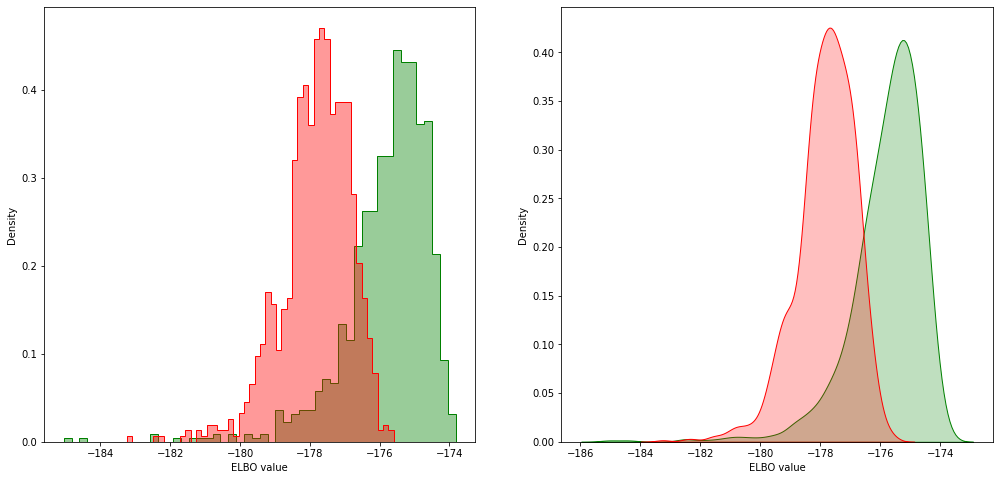

In [36]:
density_histogram_density(elbos_normal, elbos_anomaly)  # red: anomaly; green: normal 

### Accuracy

not suffice for evaluation in this case.

In [37]:
threshold=-176.6

acc = (sum(elbos_normal>threshold) + sum(elbos_anomaly<threshold))/2000*100
print("acc = %.2f%%" % (acc))

acc = 87.40%


### ROC Curve

In [38]:
def roc_pr_curves(neg, pos):
    # translate to scores from 0 to 1, where 1 means anomaly (low ELBO) and 0 means normal (high ELBO)
    min_val = min(np.min(neg), np.min(pos))
    max_val = max(np.max(neg), np.max(pos))
    y_true_neg = np.zeros(neg.shape)
    y_true_pos = np.ones(pos.shape)
    y_true = np.concatenate((y_true_neg, y_true_pos))
    y_score = (max_val - np.concatenate((neg, pos))) / (max_val - min_val)

    # get ROC curve values
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=True)
    auroc = auc(fpr, tpr)

    # plot ROC curve
    lw = 2
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # get Precision-Recall values
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auprc = auc(recall, precision)

    # plot PRC
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [no_skill, no_skill], color="navy", lw=lw, linestyle='--')
    plt.plot(recall, precision, color='darkorange',
             lw=lw, label="PR curve (AUC= %0.2f)" % auprc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")
    plt.show()

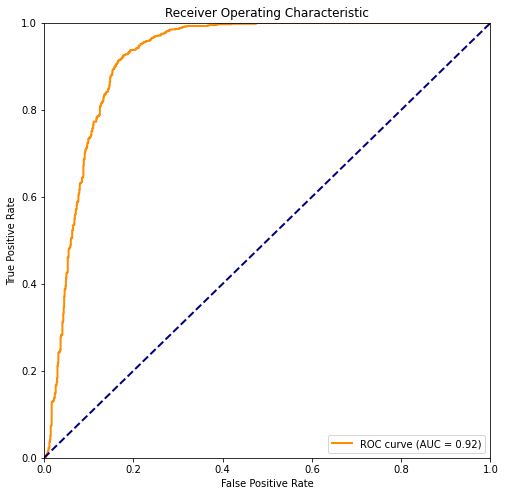

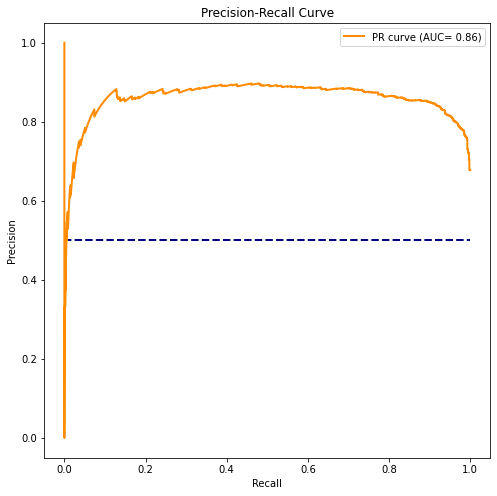

In [39]:
roc_pr_curves(elbos_normal, elbos_anomaly)